# **Environmental predictors of bird species richness across the United States: a route-based spatial analysis with a hexagonal grid comparison**
A route-based analysis of bird species richness across the contiguous United States, using BBS routes as the observational units and environmental predictors summarized along each route.


## Research objectives

Quantify spatial variation in bird species richness across the contiguous United States using BBS routes.

Assess how NDVI and elevation predict species richness at the route level.

Evaluate spatial autocorrelation in species richness and model residuals.

Explore how spatial aggregation (hexagonal grid) alters richness patterns in a regional case study (e.g. California).

Spatial aggregation

- BBS routes intersected with equal-area grid cells
- Species richness computed as unique species per cell
- NDVI summarized as mean value per cell

Spatial autocorrelation

Modelling

- Random Forest regression fitted separately for each grid resolution: randomForest(richness ~ ndvi_mean + elev_mean + elev_sd + lat + lon + n_routes + routegrid_ratio)
- Model performance evaluated using cross-validation
- Residuals mapped to identify spatial structure


## 1. Building the dataset

In [ ]:
# Libraries
import geopandas as gpd # spatial data manipulation
import pandas as pd
import httpx
import requests
import matplotlib.pyplot as plt
import io

### Study area

First load the data about the US states:

In [63]:
states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip"
r = httpx.get(states_url, verify=False, timeout=None)
us_states = gpd.read_file(r.content, engine="pyogrio")
exclude = ['AK', 'HI', 'PR', 'VI', 'MP', 'GU', 'AS'] # States outside the area of interest
states = us_states.query("STUSPS not in @exclude") # Accesing the exclude variable outside the query() string
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


In [119]:
us_boundary = states.dissolve()

### BBS data

In [67]:
url = "https://raw.githubusercontent.com/matejtvar/SDS_assignement/main/bbs_routes_SR_2018.gpkg"
r = requests.get(url)
bbs = gpd.read_file(io.BytesIO(r.content), engine = "fiona")
bbs.head()

,RTENO,RouteName,StateNum,Route,CountryNum,species_richness,geometry
0,84002001,ST FLORIAN,2,001,840,63,POINT (-87.60414 34.86869)
1,84002004,TRADE,2,004,840,51,POINT (-87.05924 34.02979)
2,84002007,SWAIM,2,007,840,63,POINT (-86.20304 34.86804)
3,84002008,PINE GROVE,2,008,840,66,POINT (-85.71104 34.02781)
4,84002010,MILLERVILLE,2,010,840,59,POINT (-85.92584 33.19135)


In [68]:
bbs = bbs.loc[bbs["CountryNum"] == 840] # Select only US transects
bbs = bbs.loc[bbs["StateNum"] != 3] # Select every state except Alaska

In [73]:
routes_url = "https://earthworks.stanford.edu/download/file/stanford-vy474dv5024-geojson.json"

# Defining headers to mimic a browser (avoids 403 Forbidden errors)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

r = requests.get(routes_url, headers=headers)

if r.status_code == 200:
    routes = gpd.read_file(io.BytesIO(r.content), engine="pyogrio")
    print(routes.info())
else:
    print(f"Failed. Status: {response.status_code}")

Skipping field bbox: unsupported OGR type: 3


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3731 entries, 0 to 3730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          3731 non-null   object  
 1   fnode_      3731 non-null   int32   
 2   tnode_      3731 non-null   int32   
 3   lpoly_      3731 non-null   int32   
 4   rpoly_      3731 non-null   int32   
 5   length      3731 non-null   float64 
 6   bbsrtsl020  3731 non-null   int32   
 7   arc_length  3731 non-null   float64 
 8   rteno       3731 non-null   int32   
 9   rtename     3730 non-null   object  
 10  rteleng     3731 non-null   float64 
 11  geometry    3731 non-null   geometry
dtypes: float64(3), geometry(1), int32(6), object(2)
memory usage: 262.5+ KB
None


In [75]:
routes = routes[['rteno', 'rteleng', 'geometry']]
routes.crs.equals(bbs.crs)


True

<Axes: >

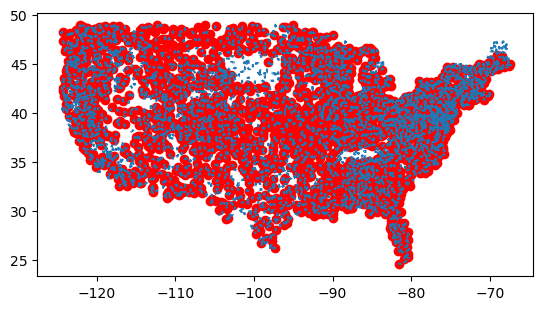

In [76]:
ax = routes.plot()
bbs.plot(ax=ax, color='red')

In [96]:
# Ensure CRS is in meters (EPSG:5070)
routes = routes.to_crs(5070)
bbs_pts = bbs.to_crs(5070)

# Add a small buffer (500 m) to points to account for GPS inaccuracy
bbs_buffered = bbs_pts.copy()
bbs_buffered['geometry'] = bbs_pts.buffer(400)

# Spatial join of bbs points data with the routes geometries
joined_data = gpd.sjoin(routes, bbs_buffered, how='inner', predicate='intersects')

# 4. Check for duplicates
# Since one point might touch two route segments, or vice versa
print(f"Matched {len(joined_data)} route-point pairs.")

# 5. Filter check
# See which routes lost their points
print(f"Routes in subset: {len(routes_subset)}")
print(f"Routes with data: {len(joined_data['rteno'].unique())}")

Matched 2036 route-point pairs.
Routes in subset: 3731
Routes with data: 2024


In [102]:
bbs_routes = joined_data.drop_duplicates(subset=['rteno']) # This ensures each route only appears once in the final dataset
bbs_routes = bbs_routes.drop(columns = ["RTENO", "CountryNum", "RouteName", "index_right", "Route"])
new_order = ['rteno', 'rteleng', 'StateNum', 'species_richness', "geometry"]
bbs_routes = bbs_routes[new_order]
bbs_routes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2024 entries, 0 to 3730
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   rteno             2024 non-null   int32   
 1   rteleng           2024 non-null   float64 
 2   StateNum          2024 non-null   int64   
 3   species_richness  2024 non-null   int64   
 4   geometry          2024 non-null   geometry
dtypes: float64(1), geometry(1), int32(1), int64(2)
memory usage: 87.0 KB


### NDVI data

Normalized Difference Vegetation Index (NDVI) describes the health of vegetation within pixels of a raster image by measuring the amount of near-infrared (NIR) light being reflected by vegetation. Healthy vegetation reflects more NIR and less red relative to unhealthy vegetation or inorganic matter of the same visible color (such as turf fields), making it convenient for assessing the relative health of vegetation in a raster image compared to its surroundings.

NDVI is calculated for each pixel with the following calculation:

$\Large NDVI = \frac{(NIR - Red)}{(NIR + Red)}$

This formula generates a value between -1 and +1. Low reflectance in the red channel and high reflectance in the NIR channel will yield a high NDVI value (healthy vegetation), while the inverse will result in a low NDVI value (unhealthy vegetation). Negative values typically represent non-vegetation such as water or rock.


In [104]:
import datashader as ds
import geopandas as gpd
import rioxarray
import osmnx as ox
import xvec

In [124]:
url = "https://raw.githubusercontent.com/matejtvar/SDS_assignement/main/MOD_NDVI_M_2018-06-01_rgb_3600x1800.TIFF"

# Download content as bytes
r = requests.get(url)

if response.status_code == 200:
    # Read from memory buffer
    ndvi = rioxarray.open_rasterio(io.BytesIO(r.content))
    print("Successfully loaded NDVI raster.")
else:
    print(f"Failed to download. Status code: {r.status_code}")

Successfully loaded NDVI raster.


In [125]:
ndvi.head()

<xarray.DataArray (band: 1, y: 5, x: 5)> Size: 25B
[25 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40B -179.9 -179.8 -179.8 -179.6 -179.5
  * y            (y) float64 40B 89.95 89.85 89.75 89.65 89.55
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [128]:
ndvi_us = ndvi.rio.clip(us_boundary.to_crs(ndvi.rio.crs).geometry)
ndvi_us

<xarray.DataArray (band: 1, y: 248, x: 577)> Size: 143kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 248, 577), dtype=uint8)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

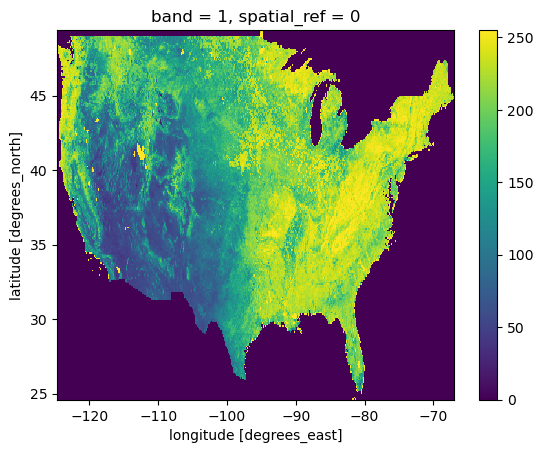

In [131]:
_ = ndvi_us.plot()

In [132]:
ndvi_us.sel(band=1)

<xarray.DataArray (y: 248, x: 577)> Size: 143kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(248, 577), dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0